We use this notebook to read in two representative leaves, one small, one large, to compare the angle test statistics.

Samples are from control group in environmental treatment.

In [1]:
import graph_create, voronoi_local, jaccard_similarity, figure_plot, figure_save


import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import shapely
import networkx as nx
import matplotlib as mpl
import seaborn as sns

-----

## Read in the graph

We read in the vein network and the dots as a combined graph object, with the single dots in non overlapping faces highlighted in orange.

In [2]:
C_dot_folder = 'environmental/dot_images/control_dots'
C_vein_folder = 'environmental/vein_graphs/control_txt'

In [27]:
def plot_dual(G, G_dual, attr = "angle"):

    'we tweak the original function a bit to plot the error of the two graph on the same color code scale.'

    node_position_G = {}
    
    node_position_dual = {}
    # node_label_dual = {}
    
    edge_color_dual = []
    
    for node in G.nodes:
        node_position_G[node] = node
    
    edge_style = ['solid' if G.edges[e]['shared'] =='tested_shared' else 'dashed' for e in G.edges]
    edge_col = ['black' if G.edges[e]['shared'] =='tested_shared' else 'C7' for e in G.edges]
    for node in G_dual.nodes:
        node_position_dual[node] = node
        # node_label_dual[node] = G_dual.nodes[node]['label']
     
    for edge in G_dual.edges:
        edge_color_dual.append(G_dual.edges[edge][attr])
    
    selected_nodes = [n for n,v in G.nodes(data=True) if v['type'] == 'vein']  
        
    fig, ax = plt.subplots(figsize=(10,10/G.graph['ratio']))
    
    nx.draw_networkx_edges(G, pos=node_position_G, edge_color = edge_col, style = edge_style, ax = ax) 
    nx.draw_networkx_nodes(G, pos=node_position_G, 
                           nodelist = selected_nodes, node_size= 5, node_color = 'C0', ax = ax) 
    nx.draw(G_dual, pos=node_position_dual, node_size= 20,  node_color= 'C1', 
            edge_color = edge_color_dual ,  edge_cmap =  plt.cm.rainbow, 
            edge_vmin = 0, edge_vmax = 60,
            width = 3, alpha = .5, ax = ax)
    
    # add colorbar:
    cbar_ax = fig.add_axes([0.2, .1, .6, 0.02])

    cb = mpl.colorbar.ColorbarBase(cbar_ax, orientation='horizontal', 
                                   cmap= plt.cm.rainbow,
                                   norm=mpl.colors.Normalize(0, 60),
                                   label=f'{attr} difference to ideal')
    
    
    plt.show()   

    # fig.savefig('angle_error.pdf')

In [4]:
small_sample = 'C2-1'

Gs = graph_create.graph_creation(small_sample, dot_folder= C_dot_folder, vein_folder= C_vein_folder)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



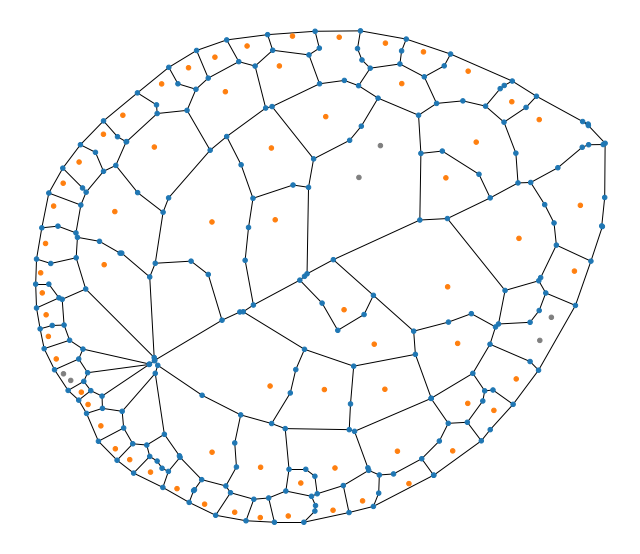

In [5]:
figure_plot.quick_plot(Gs)

-----

## Perform local tests

For the "one face - one dot" dots, we locally test the voronoi properties between it and other eligible dots in the adjacent faces. We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same.

In [6]:
# local tests:
adj_faces_mat_Gs, shared_edges_mat_Gs = voronoi_local.shared_edges(Gs, threshold = 50)
rst_Gs = voronoi_local.local_test(adj_faces_mat_Gs, shared_edges_mat_Gs, Gs.graph['dots_passed'], Gs, dot_bool = True)
rst_Gs[2]

,mean angle error,std angle error,mean distance error,std distance error
0,10.629277,8.846086,0.270683,0.204618


We use the centroid dots and random dots in the face as baselines for the local test.

-----

## Visualize local test

we color the dual edges (by connecting dots) to represent test performance.

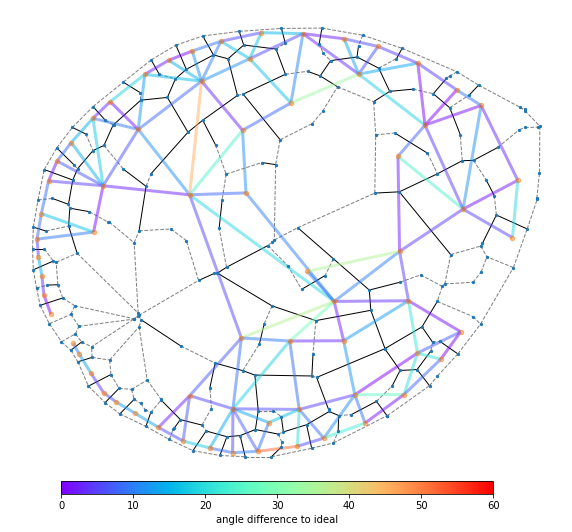

In [7]:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(Gs)

centroid_rst = voronoi_local.local_test(adj_faces_mat_Gs, shared_edges_mat_Gs, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat_Gs, shared_edges_mat_Gs ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat_Gs, shared_edges_mat_Gs, rand_in_faces)

Gs_dual = graph_create.make_dual(Gs, cent_in_faces, mid_in_faces, rand_in_faces, rst_Gs[0])
plot_dual(Gs, Gs_dual, attr = "angle")

-------
## Visualize Voronoi Overlay

Plot voronoi diagram generated by the dots as seeds. Later we'll perform area overlap test for faces.

In [8]:
seeds_Gs = [n for n in Gs.nodes if Gs.nodes[n]['type'] != 'vein']
vor_Gs = Voronoi(seeds_Gs)

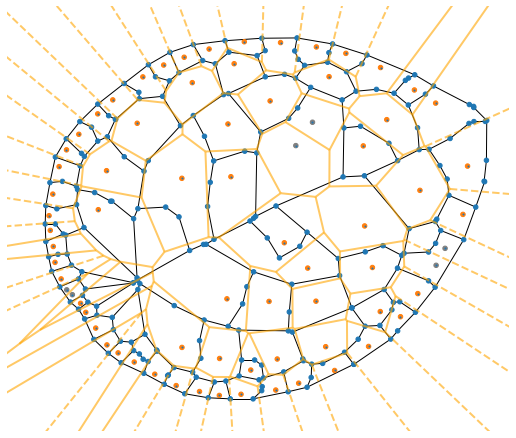

In [9]:
figure_plot.plot_voronoi(Gs, vor_Gs)

In [10]:
bounded_regions_Gs = jaccard_similarity.bounded_polygons(Gs, vor_Gs)
J_list_Gs = jaccard_similarity.overlap_test(Gs, seeds_Gs, bounded_regions_Gs, type = 'dot')

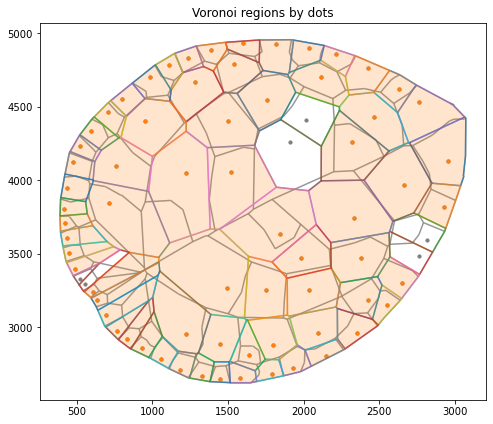

In [11]:
single_dot_Gs = [Gs.nodes[seed]['type'] == 'single_dot' for seed in seeds_Gs]

figure_plot.plot_vor_regions(Gs, seeds_Gs, single_dot_Gs, bounded_regions_Gs, dot_type = 'dots')

In [12]:
def plot_overlap_diff(G, type = 'dot', bounded_regions = bounded_regions_Gs):
    fig, ax = plt.subplots(figsize = (8, 8/G.graph['ratio']))

    node_positions = {}

    for node in G.nodes:
        node_positions[node] = node

    dot_color = {'dot':'C1', 'centroid':'red','midpoint': 'hotpink', 'random':'purple'}
    color = dot_color[type]

    # plot veins:     
    nx.draw_networkx_edges(G, pos=node_positions, edge_color = 'C7', ax = ax, width = 1.5, alpha = .8) 

    # plot voronoi polygons:
   
    for i in range(len(bounded_regions)):
        ax.plot(np.array(bounded_regions[i])[:,0], np.array(bounded_regions[i])[:,1], alpha = .7)

    # plot diff patches:
    for geom in G.graph[f'diff_geom_{type}']:  

        if isinstance(geom, shapely.geometry.polygon.Polygon):
            contour = list(geom.exterior.coords)
           
            if len(contour):
                p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                ax.add_patch(p)
                
            if len(list(geom.interiors)):
                interior = list(geom.interiors[0].coords)
                p_in = mpl.patches.Polygon(contour, facecolor = 'white', alpha = 1)
                ax.add_patch(p_in)
                
        else: # multipolygon.MultiPolygon
            for ploy in geom:
                contour = list(ploy.exterior.coords)
                if len(contour):
                    p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                    ax.add_patch(p)
                    
                if len(list(ploy.interiors)):
                    interior = list(ploy.interiors[0].coords)
                    p_in = mpl.patches.Polygon(interior, facecolor = 'white', alpha = 1)
                    ax.add_patch(p_in)

    plt.show()


        

<ipython-input-12-46c8013ec7d0>:36: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


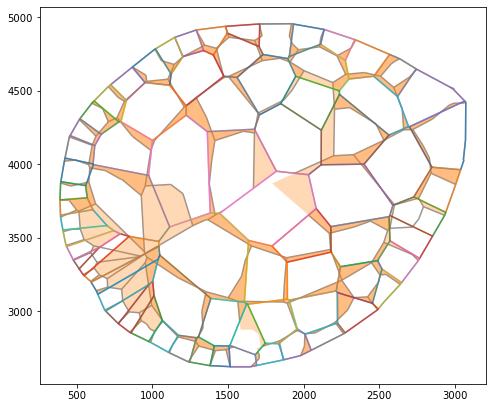

In [13]:
plot_overlap_diff(Gs, type = 'dot', bounded_regions = bounded_regions_Gs)

In [14]:
large_sample = 'C3-5'

Gl = graph_create.graph_creation(large_sample, dot_folder= C_dot_folder, vein_folder= C_vein_folder)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



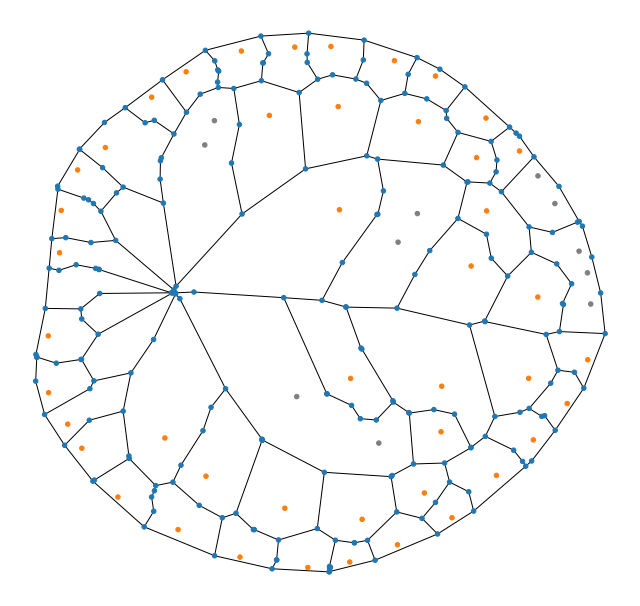

In [15]:
figure_plot.quick_plot(Gl)

-----

## Perform local tests

For the "one face - one dot" dots, we locally test the voronoi properties between it and other eligible dots in the adjacent faces. We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same.

In [16]:
# local tests:
adj_faces_mat_Gl, shared_edges_mat_Gl = voronoi_local.shared_edges(Gl, threshold = 50)
rst_Gl = voronoi_local.local_test(adj_faces_mat_Gl, shared_edges_mat_Gl, Gl.graph['dots_passed'], Gl, dot_bool = True)
rst_Gl[2]

,mean angle error,std angle error,mean distance error,std distance error
0,7.470857,6.480592,0.233066,0.202441


We use the centroid dots and random dots in the face as baselines for the local test.

-----

## Visualize local test

we color the dual edges (by connecting dots) to represent test performance.

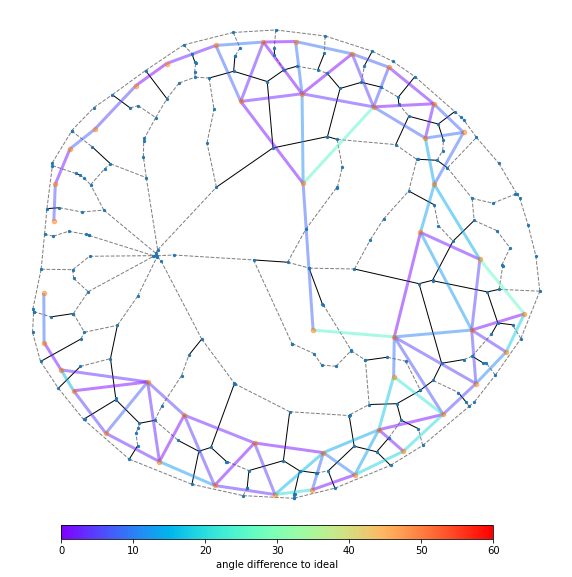

In [17]:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(Gl)

centroid_rst = voronoi_local.local_test(adj_faces_mat_Gl, shared_edges_mat_Gl, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat_Gl, shared_edges_mat_Gl ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat_Gl, shared_edges_mat_Gl, rand_in_faces)

Gl_dual = graph_create.make_dual(Gl, cent_in_faces, mid_in_faces, rand_in_faces, rst_Gl[0])
plot_dual(Gl, Gl_dual, attr = "angle")

-------
## Visualize Voronoi Overlay

Plot voronoi diagram generated by the dots as seeds. Later we'll perform area overlap test for faces.

In [18]:
seeds_Gl = [n for n in Gl.nodes if Gl.nodes[n]['type'] != 'vein']
vor_Gl = Voronoi(seeds_Gl)

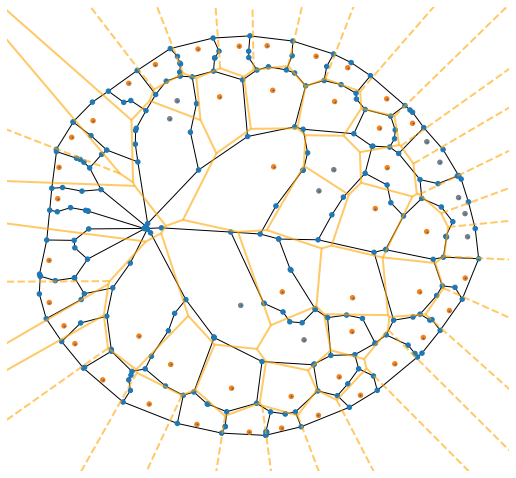

In [19]:
figure_plot.plot_voronoi(Gl, vor_Gl)

In [20]:
bounded_regions_Gl = jaccard_similarity.bounded_polygons(Gl, vor_Gl)
J_list_Gl = jaccard_similarity.overlap_test(Gl, seeds_Gl, bounded_regions_Gl, type = 'dot')

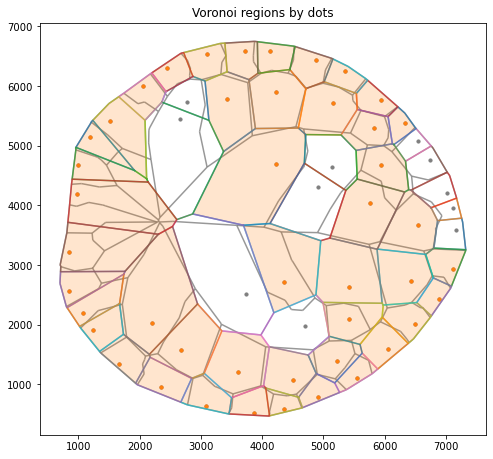

In [21]:
single_dot_Gl = [Gl.nodes[seed]['type'] == 'single_dot' for seed in seeds_Gl]

figure_plot.plot_vor_regions(Gl, seeds_Gl, single_dot_Gl, bounded_regions_Gl, dot_type = 'dots')

<ipython-input-12-46c8013ec7d0>:36: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


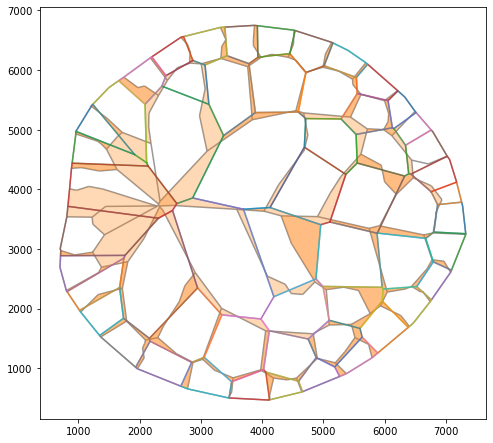

In [22]:
plot_overlap_diff(Gl, type = 'dot', bounded_regions = bounded_regions_Gl)

In [23]:
Gs_df = rst_Gs[1]
Gs_df['stage'] = 'younger'

In [24]:
Gl_df = rst_Gl[1]
Gl_df['stage'] = 'older'

In [25]:
df = pd.concat([Gs_df, Gl_df])
df.reset_index(level=0, inplace=True)

Plot error distribution...

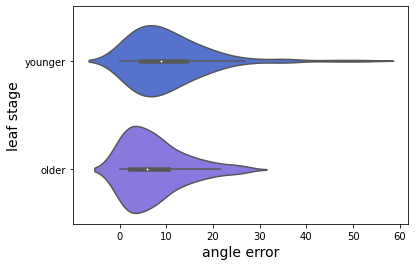

In [26]:
x = 'angle_diff'
y = 'stage'

colors = ['royalblue', 'mediumslateblue']
sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(figsize = (6,4))
ax = sns.violinplot(x = x, y = y, data = df, width = .8)

ax.set_xlabel('angle error', fontsize = 14)
ax.set_ylabel('leaf stage', fontsize = 14)

plt.show()
fig.savefig('angle_diff_small_large.pdf', dpi=300, bbox_inches='tight')